In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

/home/amin/Software/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("clean_train.csv")
test = pd.read_csv("clean_test.csv")
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

('Train shape : ', (3694, 317))
('Test shape : ', (4209, 316))


In [3]:
dtrain = train[["ID", "X0", "y"]]
X0 = dtrain.groupby("X0")["y"].agg({"med": np.median, "mean": np.mean, "max": np.max}).reset_index()

In [4]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder() 
lbl.fit(list(X0["med"].values))
X0["X0_med"] = lbl.transform(list(X0["med"].values))

lbl = LabelEncoder() 
lbl.fit(list(X0["mean"].values))
X0["X0_mean"] = lbl.transform(list(X0["mean"].values))

lbl = LabelEncoder() 
lbl.fit(list(X0["max"].values))
X0["X0_max"] = lbl.transform(list(X0["max"].values))

In [5]:
X0.head()

,X0,med,max,mean,X0_med,X0_mean,X0_max
0,a,111.42,142.71,115.048421,38,42,32
1,aa,152.17,169.91,152.170000,45,46,45
2,ab,112.30,112.30,112.300000,39,34,10
3,ac,89.62,89.62,89.620000,3,2,1
4,ad,90.79,115.95,94.087857,10,15,14


In [6]:
dtrain = pd.merge(dtrain, X0, on="X0")
dtrain.head()

,ID,X0,y,med,max,mean,X0_med,X0_mean,X0_max
0,0,k,130.81,88.63,130.81,98.362857,2,22,24
1,6,k,88.53,88.63,130.81,98.362857,2,22,24
2,281,k,90.54,88.63,130.81,98.362857,2,22,24
3,444,k,87.66,88.63,130.81,98.362857,2,22,24
4,1451,k,88.55,88.63,130.81,98.362857,2,22,24


In [7]:
dtest = test[["ID", "X0"]]
dtest = pd.merge(dtest, X0[["X0", "med", "max", "mean", "X0_med", "X0_mean", "X0_max"]], on="X0", how="left")
dtest.head()

,ID,X0,med,max,mean,X0_med,X0_mean,X0_max
0,1,az,76.81,104.65,78.134395,1.0,1.0,6.0
1,2,t,91.62,150.43,93.811613,15.0,10.0,37.0
2,3,az,76.81,104.65,78.134395,1.0,1.0,6.0
3,4,az,76.81,104.65,78.134395,1.0,1.0,6.0
4,5,w,110.12,154.43,112.675549,34.0,38.0,39.0


In [8]:
dtest[dtest["med"].isnull()] = X0["med"].median()
dtest[dtest["mean"].isnull()] = X0["mean"].median()
dtest[dtest["max"].isnull()] = X0["max"].median()

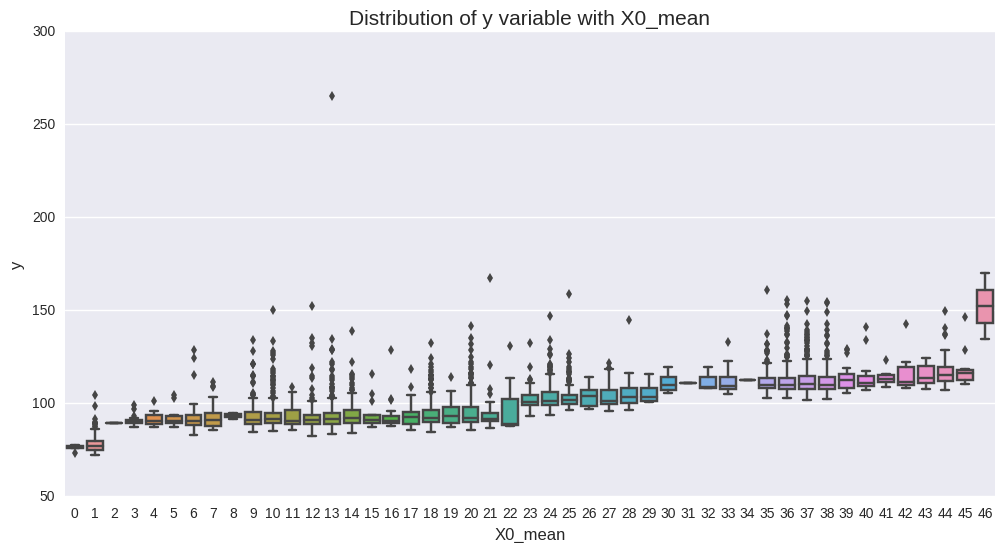

In [9]:
var_name = "X0_mean"
col_order = np.sort(dtrain[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='y', data=dtrain, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

In [10]:
train[["med", "max", "mean", "X0_med", "X0_mean", "X0_max"]] = dtrain[["med", "max", "mean", "X0_med", "X0_mean", "X0_max"]]
test[["med", "max", "mean", "X0_med", "X0_mean", "X0_max"]] = dtest[["med", "max", "mean", "X0_med", "X0_mean", "X0_max"]]
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

('Train shape : ', (3694, 323))
('Test shape : ', (4209, 322))


In [11]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [12]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD

n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]
    
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

('Train shape : ', (3694, 383))
('Test shape : ', (4209, 382))


In [13]:
# drop the outliers
index = train.y.values < 250
train = train[index]
print("Train shape : ", train.shape)

('Train shape : ', (3693, 383))


In [14]:
y = train["y"]
#train.pop('ID')
#test_ids = test.pop('ID')
train = train.drop("y", axis=1)
print("Train shape : ", train.shape)

('Train shape : ', (3693, 382))


In [18]:
# MultiTaskElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import grid_search
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

model = make_pipeline(StandardScaler(), PolynomialFeatures(), linear_model.ElasticNet(max_iter=5000))
parameters = {'elasticnet__alpha' : map(lambda x: x/10.0, range(1,5)), 
              'elasticnet__l1_ratio' : map(lambda x: x/10.0, range(10,15)),
              'polynomialfeatures__degree' : [1]} #, 
              #'polynomialfeatures__interaction_only' :[True, False]}


r2_scorer = make_scorer(r2_score)
grid = grid_search.GridSearchCV(estimator=model, param_grid=parameters, scoring=r2_scorer, cv=5)
grid_obj = grid.fit(train, y)

grid_best = grid_obj.best_estimator_
print grid_best

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('elasticnet', ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=1.1,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])


In [19]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 44)

train_pred = [0 for i in range(train.shape[0])]
test_pred = [0 for i in range(test.shape[0])]

for train_index, test_index in skf.split(train, y):
    x0, x1 = train.iloc[train_index], train.iloc[test_index]
    y0, y1 = y.iloc[train_index], y.iloc[test_index] 
    grid_best.fit(x0, y0)                
    
    pred = grid_best.predict(x1)
    print r2_score(y1, pred)
    for ii, idx in enumerate(test_index):
        train_pred[idx] = pred[ii]
    
    pred_test = grid_best.predict(test)
    for ii, val in enumerate(pred_test):
        test_pred[ii] += val
    


0.593237187702
0.623317789459
0.574542582921
0.586696685555
0.551385455815


In [20]:
train["El1"] = train_pred
test["El1"] = map(lambda x: x/5.0, test_pred) # divided by number of CV

In [21]:
train.to_csv('clean_train_El1.csv', index=False)
test.to_csv('clean_test_El1.csv', index=False)